<a href="https://colab.research.google.com/github/ThijsVercammen/Masterproef/blob/main/YOLO_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instaleer nodige tools

In [1]:
!pip install onnxruntime
!pip install -U tf2onnx
!pip install "opencv-python-headless<4.3"
!pip install brambox


     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 435 kB 5.0 MB/s 
     |████████████████████████████████| 12.7 MB 52.8 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
     |████████████████████████████████| 21.6 MB 1.4 MB/s 
     |████████████████████████████████| 927 kB 5.1 MB/s 


Imports en definiëren van YOLO Keras model

In [2]:
from tensorflow import keras
import tensorflow as tf
from datetime import datetime

In [3]:
import argparse
import os
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
import cv2

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model


Download gewichten en testafbeelding

In [4]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://machinelearningmastery.com/wp-content/uploads/2019/03/zebra.jpg

--2022-01-14 08:50:43--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  39.5MB/s    in 6.3s    

2022-01-14 08:50:50 (37.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2022-01-14 08:50:50--  https://machinelearningmastery.com/wp-content/uploads/2019/03/zebra.jpg
Resolving machinelearningmastery.com (machinelearningmastery.com)... 172.67.72.46, 104.26.0.148, 104.26.1.148, ...
Connecting to machinelearningmastery.com (machinelearningmastery.com)|172.67.72.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64972 (63K) [image/jpeg]
Saving to: ‘zebra.jpg’

zebra.jpg           100%[===================>]  63.45K  --.-KB/s    in 0.01s   

2022-01-1

Initialiseer model, en laad de YOLO gewichten

In [5]:
model = make_yolov3_model()
weight_reader = WeightReader('yolov3.weights')
weight_reader.load_weights(model)
model.save('model.h5')
tf.saved_model.save(model, "./save")

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


INFO:tensorflow:Assets written to: ./save/assets


Init Helper functies

In [7]:
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout_lite(netout, anchors, obj_thresh, net_h, net_w, mOutWidth):
	mObjTresh = obj_thresh
	boxes = []

	for i in range(len(mOutWidth)):
		gridWidth = mOutWidth[i]
		output = netout[i]
		for y in range(gridWidth):
			for x in range(gridWidth):
				for b in range(3):
					output[0][y][x][b][4:] = _sigmoid(output[0][y][x][b][4:])
					output[0][y][x][b][5:] *= output[0][y][x][b][5:] > obj_thresh

					objectness = output[0][y][x][b][4] 
					output[0][y][x][b][5:] = _sigmoid(output[0][y][x][b][5:])
					output[0][y][x][b][5:] *= output[0][y][x][b][5:] > obj_thresh
					classes = output[0][y][x][b][5:]
					max1 = np.argmax(classes)
					if (classes[max1]*objectness) > 0.5:
						if(objectness.all() <= obj_thresh): continue
						xPos = (x + _sigmoid(output[0][y][x][b][0]))  / gridWidth
						yPos = (y + _sigmoid(output[0][y][x][b][1])) / gridWidth
						w = anchors[i][2 * b + 0] * np.exp(output[0][y][x][b][2]) / net_w
						h = anchors[i][2 * b + 1] * np.exp(output[0][y][x][b][3]) / net_h
			
						box = BoundBox(max(0, xPos - w / 2), max(0, yPos - h / 2), min(net_w - 1, xPos + w / 2), min(net_h - 1, yPos + h / 2), objectness, classes)
						boxes.append(box)
	return boxes
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = ((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = ((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = ((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = ((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	#print("{}, {}, {}, {}".format(w1, h1, w2, h2))
	if union == 0:
		iou = 0
	else:
		iou = float(intersect) / union

	return iou
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
 
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
		# voor evaluatie plaats uit comment
				v_labels.append(i)
		# plaats in comment voor evaluatie
				#v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

In [8]:
def post_process(output, anchors, mOutWidth, lite, imgage_h, image_w):
  class_threshold = 0.5
  boxes = list()

  if lite:
    boxes = decode_netout_lite(output, anchors, class_threshold, 416, 416, mOutWidth)
  if lite == False:
    for i in range(len(output)):
	  # decode the output of the network
      boxes += decode_netout(output[i][0], anchors[i], class_threshold, 416, 416)
  correct_yolo_boxes(boxes, image_h, image_w, 416, 416)
  do_nms(boxes, 0.5)
  labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
  
  return v_boxes, v_labels, v_scores

Voer standaard model uit met test afbeelding

In [ ]:
model = load_model('model.h5')

photo_filename = 'zebra.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (416, 416))
now = datetime.now()
yhat = model.predict(image)
print(datetime.now()-now)
print(yhat[0][0][0][1][:85])
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
mOutWidth = [13,26,52]
v_boxes, v_labels, v_scores = post_process(yhat, anchors, mOutWidth, False, image_h, image_w)
print(datetime.now()-now)
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)


Definieer input en output formaat

In [9]:
m = load_model('model.h5')
inputs = tf.keras.Input(shape=[416,416,3], dtype=tf.float32)
output = m(inputs)
output[0] =  tf.reshape(output[0], (1, 13,13,3,85 ))
output[1] =  tf.reshape(output[1], (1, 26,26,3,85 ))
output[2] =  tf.reshape(output[2], (1, 52,52,3,85 ))
mod = tf.keras.Model(inputs, output)
tf.saved_model.save(mod, "./save")

INFO:tensorflow:Assets written to: ./save/assets


Converteer naar TFLite formaat

In [10]:
_TFLITE_MODEL_PATH = "model.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(mod)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()


with open(_TFLITE_MODEL_PATH, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp9ri1ramn/assets


Voer TFLite model uit op testafbeelding

0:00:02.112189
0:00:02.591414


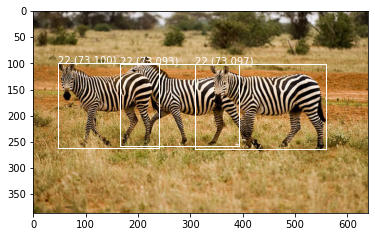

In [11]:
interpreter = tf.lite.Interpreter(model_path="./model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image, image_w, image_h = load_image_pixels("/content/zebra.jpg", (416, 416))

interpreter.set_tensor(input_details[0]['index'], image)
now = datetime.now()
interpreter.invoke()
print(datetime.now()-now)
output_data1 = interpreter.get_tensor(output_details[0]['index'])
output_data2 = interpreter.get_tensor(output_details[1]['index'])
output_data3 = interpreter.get_tensor(output_details[2]['index'])
out = [output_data3, output_data1, output_data2]

anchors = [[116,90, 156,198, 373,326], [10,13, 16,30, 33,23], [30,61, 62,45, 59,119]]
mOutWidth = [13,52,26]
# define the probability threshold for detected objects

v_boxes, v_labels, v_scores = post_process(out, anchors, mOutWidth, True, image_h, image_w)
print(datetime.now()-now)
draw_boxes("/content/zebra.jpg", v_boxes, v_labels, v_scores)

Converteer naar ONNX

In [ ]:
!python -m tf2onnx.convert --saved-model ./save --output model_3.onnx
#!python -m tf2onnx.convert --tflite ./model.tflite --output model_lite.onnx

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-01-13 12:30:53,586 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-01-13 12:31:05,293 - INFO - Signatures found in model: [serving_default].
2022-01-13 12:31:05,293 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-01-13 12:31:05,295 - INFO - Output names: ['tf.reshape', 'tf.reshape_1', 'tf.reshape_2']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-01-13 12:31:11,690 - WARNING - From /usr/local/lib/python3.7/dist-packages/tf2onnx/tf_loader.py:706: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-01

0:00:01.030206
0:00:06.684882


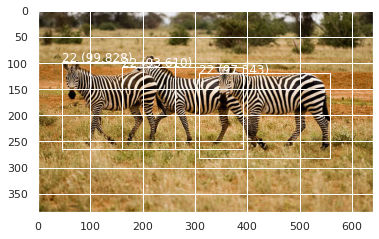

In [ ]:
import onnx
import onnxruntime as ort

image, image_w, image_h = load_image_pixels("/content/zebra.jpg", (416, 416))
ort_session = ort.InferenceSession("model_3.onnx")
now = datetime.now()
output = ort_session.run(None, {"input_2": image})
#output
print(datetime.now()-now)

anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
mOutWidth = [13,26,52]
v_boxes, v_labels, v_scores = post_process(output, anchors, mOutWidth, False, image_h, image_w)
print(datetime.now()-now)
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)
v_boxes

Evalueer de modellen

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip

from pycocotools.coco import COCO

img_dir=('/content/val2017')
annotations_file='/content/annotations/instances_val2017.json'
coco=COCO(annotations_file)

imgIds = coco.getImgIds()
print("Total images: {}".format(len(imgIds)))

loading annotations into memory...
Done (t=1.23s)
creating index...
index created!
Total images: 5000


In [ ]:
import onnx
import onnxruntime as ort

results_cs = []
results_cs_l = []
results_cs_o = []

model = load_model('model.h5')
ort_session = ort.InferenceSession("model_3.onnx")
interpreter = tf.lite.Interpreter(model_path="./model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

class_label_map=[lines.strip() for lines in open('coco.names')]

z = 0

for x in coco.imgs:
  val = coco.imgs.get(x)
  imageName = val['file_name']
  imgpath = "/content/val2017/"+imageName
  print("index: {} Image: {}".format(z, imageName))
  image, image_w, image_h = load_image_pixels(imgpath, (416, 416))
  image_e = imageName[:12]

  output = ort_session.run(None, {"input_2": image})
    
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()
  output_data1 = interpreter.get_tensor(output_details[0]['index'])
  output_data2 = interpreter.get_tensor(output_details[1]['index'])
  output_data3 = interpreter.get_tensor(output_details[2]['index'])
  out = [output_data3, output_data1, output_data2]

  yhat = model.predict(image)

  anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
 anchors_onnx = [[10,13, 16,30, 33,23], [30,61, 62,45, 59,119], [116,90, 156,198, 373,326]]
  anchors_l = [[116,90, 156,198, 373,326], [10,13, 16,30, 33,23], [30,61, 62,45, 59,119]]
  mOutWidth = [13,26,52]
  mOutWidth_l= [13,52,26]
  mOutWidth_onnx = [52,26,13]

  d_boxes, d_labels, d_scores = post_process(yhat, anchors, mOutWidth, False, image_h, image_w)
  o_boxes, o_labels, o_scores = post_process(output, anchors, mOutWidth, False, image_h, image_w)
  l_boxes, l_labels, l_scores = post_process(out, anchors_l, mOutWidth_l, True, image_h, image_w)

  for i in range(len(d_boxes)):
    w1, h1 = d_boxes[i].xmax-d_boxes[i].xmin, d_boxes[i].ymax-d_boxes[i].ymin
    results_cs.append([int(image_e), class_label_map[int(d_labels[i])], None, d_boxes[i].xmin, d_boxes[i].ymin, w1, h1, float(d_scores[i])])
  
  for i in range(len(o_boxes)):
    w1, h1 = o_boxes[i].xmax-o_boxes[i].xmin, o_boxes[i].ymax-o_boxes[i].ymin
    results_cs_o.append([int(image_e), class_label_map[int(o_labels[i])], None, o_boxes[i].xmin, o_boxes[i].ymin, w1, h1, float(o_scores[i])])
  
  for i in range(len(d_boxes)):
    w1, h1 = l_boxes[i].xmax-l_boxes[i].xmin, l_boxes[i].ymax-l_boxes[i].ymin
    results_cs_l.append([int(image_e), class_label_map[int(l_labels[i])], None, l_boxes[i].xmin, l_boxes[i].ymin, w1, h1, float(l_scores[i])])

  z += 1

Bereken mAP met Brambox

In [ ]:
# Basic imports
import brambox as bb
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
sns.set(style='darkgrid', context='notebook')  # Nicer plotting colors
bb.logger.setConsoleLevel('ERROR')             # Only show error log messages

anno = bb.io.load('anno_coco', '/content/annotations/instances_val2017.json')
anno.head()

In [ ]:
fields = ['image', 'class_label', 'id', 'x_top_left', 'y_top_left', 'width', 'height', "confidence"]
df = pd.DataFrame(results_cs, columns=fields)
df.to_pickle("res_d.pkl")

In [ ]:
class_label_map=[lines.strip() for lines in open('coco.names')]
det = bb.io.load(
    'pandas',
    'res_d.pkl',
    class_label_map
    # We need to map the numbers from the JSON file to actual classnames
    #class_label_map=[lines.strip() for lines in open('coco.names')]
)

# The image labels are just numbers in the COCO json files, so we need to rename those as well
det.image = det.image.cat.rename_categories(lambda img: f'{img:012}')

# Finally, not all images might contain detections,
# and because the coco detection format does not contain a list of all images, we need to fix this ourselves
# Note that this is optional, but you will get a warning if you dont do this
det.image = det.image.cat.add_categories(set(anno.image.cat.categories) - set(det.image.cat.categories))

det.head()

In [ ]:
# Filter detections
det_filtered = det.sort_values('confidence').groupby('image').head(100)

# For each class
aps = []
for label in anno.class_label.unique():
    ac = anno[anno.class_label == label]
    dc = det_filtered[det_filtered.class_label == label]

    # Compute smoothed PR
    pr = bb.stat.pr(dc, ac, 0.5, smooth=True)

    # Compute interpolated Riemann
    aps.append(bb.stat.auc_interpolated(pr))

# Compute average mAP
mAP_50 = sum(aps) / len(aps)

mAP_50

In [ ]:
coco = bb.eval.COCO(det, anno)
coco.mAP